In [1]:
import pandas as pd
import tensorflow as tf
import yfinance as yf
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input,GlobalAveragePooling1D, Bidirectional
from keras import optimizers
import matplotlib.pyplot as plt
import keras_tuner as kt
from datetime import datetime, timedelta
import math

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
policy = keras.mixed_precision.Policy('mixed_float16')
keras.mixed_precision.set_global_policy(policy)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14369731644598487697
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5729419264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14567462073628755670
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [3]:
timestep = 100
testfrac = 0.25
valfrac = 0.2

In [4]:
start_date = '2010-01-01'
today = datetime.now()
end_date = datetime.strftime(today, '%Y-%m-%d')
display(end_date)
data = yf.download("ETH-USD", start=start_date, end=end_date) #Displays till yesterday as today is not complete
data = data.reset_index()
dataclose = np.array([data['Close']]).transpose()
display(dataclose.shape)

'2024-01-29'

[*********************100%%**********************]  1 of 1 completed


(2271, 1)

,Open,High,Low,Close,Volume
0,308.644989,329.451996,307.056000,320.884003,893249984
1,320.670990,324.717987,294.541992,299.252991,885985984
2,298.585999,319.453003,298.191986,314.681000,842300992
3,314.690002,319.153015,298.513000,307.907990,1613479936
4,307.024994,328.415009,307.024994,316.716003,1041889984
...,...,...,...,...,...
2266,2310.951660,2348.031250,2167.282471,2240.686035,16182147521
2267,2241.749756,2261.384521,2197.656738,2233.561768,10134722960
2268,2233.969971,2240.380859,2173.686523,2217.710205,9302247037
2269,2217.441895,2280.383789,2196.140137,2267.199707,9975117607


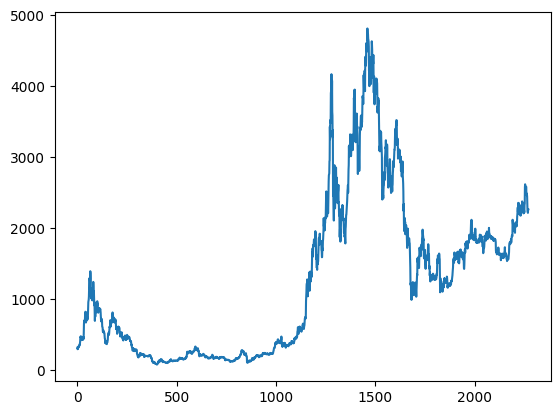

In [5]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
display(data)
plt.plot(dataclose)
plt.show()

In [6]:
Xscaler = MinMaxScaler()
Xdata = Xscaler.fit_transform(np.array(data))
Yscaler = MinMaxScaler()
Ydata = Yscaler.fit_transform(dataclose)
display(Xdata.shape)
display(Ydata.shape)

(2271, 5)

(2271, 1)

In [7]:
X_temp, X_test = train_test_split(Xdata, test_size=testfrac, shuffle=False)
Y_temp, Y_test = train_test_split(Ydata, test_size=testfrac, shuffle=False)
X_train, X_val = train_test_split(X_temp, test_size=valfrac, shuffle=False)
Y_train, Y_val = train_test_split(Y_temp, test_size=valfrac, shuffle=False)

In [8]:
def build_timeseries(Xdata, Ydata, time_step):
    dim_0 = Xdata.shape[0] - time_step
    dim_1 = Xdata.shape[1]

    x = np.zeros((dim_0, time_step, dim_1))
    y = np.zeros((Ydata.shape[0] - time_step,))

    for i in range(dim_0):
        x[i] = Xdata[i:time_step+i]
        y[i] = Ydata[time_step+i]
    return x, y

In [9]:
X_train, Y_train = build_timeseries(X_train, Y_train, timestep)
X_test, Y_test = build_timeseries(X_test, Y_test, timestep)
X_val, Y_val = build_timeseries(X_val, Y_val, timestep)
print("X Train Shape: ", X_train.shape, "   Y Train Shape: ", Y_train.shape)
print("X Val Shape: ", X_val.shape, "   Y Val Shape: ", Y_val.shape)
print("X Test Shape: ", X_test.shape, "   Y Test Shape: ", Y_test.shape)

X Train Shape:  (1262, 100, 5)    Y Train Shape:  (1262,)
X Val Shape:  (241, 100, 5)    Y Val Shape:  (241,)
X Test Shape:  (468, 100, 5)    Y Test Shape:  (468,)


C:\Users\user\AppData\Local\Temp\ipykernel_55024\2375792492.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = Ydata[time_step+i]


In [10]:
def model_builder(hp):
    lstm_model = Sequential()
    
    lstm_units_0 = hp.Int('units_lstm_0', min_value=32, max_value=512, step=32)
    lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    lstm_model.add(Bidirectional(LSTM(units=lstm_units_0, return_sequences=True)))
    lstm_model.add(Dropout(0.05))
    lstm_model.add(Bidirectional(LSTM(units=int(lstm_units_0/4), return_sequences=True)))
    lstm_model.add(Dropout(0.05))
    lstm_model.add(Bidirectional(LSTM(units=int(lstm_units_0/4), return_sequences=True)))
    lstm_model.add(Dropout(0.05))
    lstm_model.add(Bidirectional(LSTM(int(lstm_units_0/8), return_sequences=True)))
    lstm_model.add(GlobalAveragePooling1D())
    lstm_model.add(Dense(units=int(lstm_units_0/4),activation='relu'))
    lstm_model.add(Dense(units=int(lstm_units_0/4),activation='relu'))
    lstm_model.add(Dense(units=int(lstm_units_0/4),activation='relu'))
    lstm_model.add(Dense(units=1, activation='linear'))
    lstm_model.summary()
    
    hyperparameters_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.05, 0.1])
    
    lstm_model.compile(loss='huber_loss', optimizer=keras.optimizers.Adam(learning_rate=hyperparameters_learning_rate))
    
    return lstm_model

In [11]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=50)
tuner.search(X_train, Y_train, epochs=100, validation_data=(X_val,Y_val))
lstm_model  = tuner.get_best_models()[0]  
print(lstm_model.summary())
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Reloading Tuner from .\untitled_project\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 128)         35840     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 32)          18560     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 100, 32)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 32)          6272      
 nal)                                                            
    

In [12]:
model_fit = lstm_model.fit(X_train,Y_train,validation_data = (X_val,Y_val),epochs = 100,batch_size = 16,verbose = 1)
lstm_model.save("ETH_LSTM.keras")

Epoch 1/100
79/79 [==============================] - 16s 80ms/step - loss: 4.8062e-04 - val_loss: 0.0019
Epoch 2/100
79/79 [==============================] - 4s 57ms/step - loss: 6.4144e-04 - val_loss: 0.0049
Epoch 3/100
79/79 [==============================] - 5s 58ms/step - loss: 4.8540e-04 - val_loss: 0.0024
Epoch 4/100
79/79 [==============================] - 5s 58ms/step - loss: 2.9591e-04 - val_loss: 0.0014
Epoch 5/100
79/79 [==============================] - 4s 57ms/step - loss: 2.6802e-04 - val_loss: 0.0023
Epoch 6/100
79/79 [==============================] - 4s 55ms/step - loss: 3.3440e-04 - val_loss: 0.0029
Epoch 7/100
79/79 [==============================] - 4s 56ms/step - loss: 3.2349e-04 - val_loss: 0.0015
Epoch 8/100
79/79 [==============================] - 4s 56ms/step - loss: 2.1472e-04 - val_loss: 0.0022
Epoch 9/100
79/79 [==============================] - 4s 57ms/step - loss: 2.4831e-04 - val_loss: 0.0017
Epoch 10/100
79/79 [==============================] - 5s 63ms/s

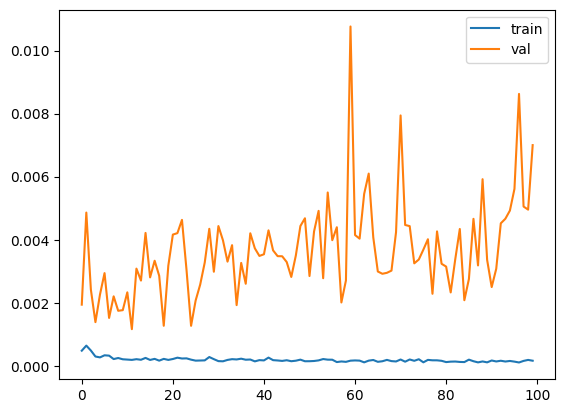

In [13]:
plt.plot(model_fit.history['loss'], label='train')
plt.plot(model_fit.history['val_loss'], label='val')
plt.legend()
plt.show()

In [14]:
train_predict = lstm_model.predict(X_train)
val_predict = lstm_model.predict(X_val)
test_predict = lstm_model.predict(X_test)
train_predictraw = Yscaler.inverse_transform(train_predict).reshape((train_predict.shape[0],))
val_predictraw = Yscaler.inverse_transform(val_predict).reshape((val_predict.shape[0],))
test_predictraw = Yscaler.inverse_transform(test_predict).reshape((test_predict.shape[0],))

15/15 [==============================] - 0s 28ms/step


In [15]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_val,val_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

0.019573611944491483
0.11832194670375097
0.012991377251969643


In [16]:
dataclose = dataclose.transpose()[0]
display(dataclose)

array([ 320.88400269,  299.25299072,  314.68099976, ..., 2217.71020508,
       2267.19970703, 2267.88598633])

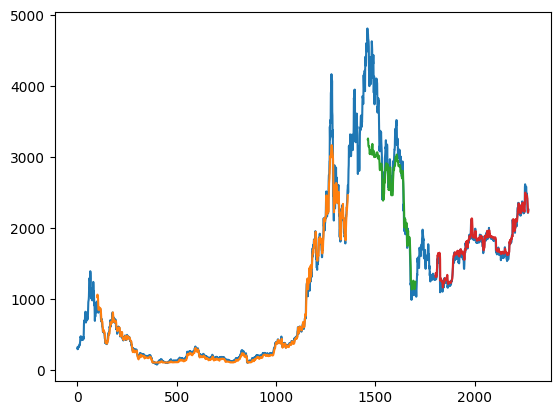

In [17]:
plt.plot(dataclose)

trainPredictPlot = np.empty_like(dataclose)
trainPredictPlot.fill(np.nan)
trainPredictPlot[timestep:len(train_predictraw)+timestep:] = train_predictraw
plt.plot(trainPredictPlot)

valPredictPlot = np.empty_like(dataclose)
valPredictPlot.fill(np.nan)
valPredictPlot[len(train_predictraw)+timestep*2:len(train_predictraw)+timestep*2+len(val_predictraw):] = val_predictraw
plt.plot(valPredictPlot)

testPredictPlot = np.empty_like(dataclose)
testPredictPlot.fill(np.nan)
testPredictPlot[len(train_predictraw)+timestep*3+len(val_predictraw):len(train_predictraw)+timestep*3+len(val_predictraw)+len(test_predictraw):] = test_predictraw
plt.plot(testPredictPlot)

plt.show()